# **Step 1: Problem Definition**

## **Introduction to the Problem:**
In marketing and customer management, understanding and meeting customer needs is essential for building effective business strategies. However, providing a single product or promotion that serves all customers is a significant challenge, especially in Direct-to-Customer (DTC) and retail models. To address this issue, businesses are shifting towards customer segmentation, identifying and focusing on specific groups based on their unique characteristics and shopping behaviors.

With the rapid development of data science and AI, collecting and analyzing customer data has become a valuable resource. This enables businesses to make data-driven decisions, optimizing DTC sales strategies and improving customer care, ultimately increasing their competitiveness in a challenging market.

### ***Why Use RFM Analysis?***

RFM analysis (Recency, Frequency, Monetary) is a powerful customer segmentation method that helps businesses gain a deeper understanding of customer behavior and develop more effective marketing and sales strategies. RFM evaluates three key factors:

- Recency: How recent was the customer’s last purchase?
- Frequency: How often does the customer make purchases?
- Monetary: How much money does the customer spend?

RFM analysis helps identify high-value customers, at-risk customers, and opportunities to increase customer retention and sales through cross-selling and up-selling strategies.

### ***Why K-Means++ Clustering?***

K-Means++ is an improved version of the traditional K-Means algorithm, designed to optimize the initialization of cluster centroids, leading to better clustering performance. This method helps group customers into meaningful segments based on their RFM values, supporting the development of optimized DTC strategies, particularly in predicting customer behavior and tailoring marketing efforts accordingly.

### ***Dataset Description***

This project uses a customer transaction dataset from Adventure Works Cycles, a multinational company that manufactures and sells bicycles across North American, European, and Asian markets. The dataset includes 121,253 transactions from 07/01/2017 to 07/15/2020, encompassing both individual customers and resellers (retailers).

I applied EDA techniques and then used machine learning algorithms (K-Means++) in this notebook, to find some intererting and important insight, then segment customers. This approach aims to optimize sales strategies, predict customer behavior, and develop targeted marketing strategies that enhance customer engagement and retention.
[raw dataset](https://docs.google.com/spreadsheets/d/1u5UGNMHYAhuF895_bAiLNxk3fAlISreA/edit?usp=sharing&ouid=110277384668212339161&rtpof=true&sd=true)

# **Step 2: Data preparation and EDA**
Load, clean, and prepare data for further analysis and EDA.



## Import Necessary Libraries
Before processing the dataset, we need to import essential libraries for data handling, visualization, and clustering.

In [ ]:
# Ensure required libraries are installed before running:
!pip install squarify scikit-learn-extra lifetimes

In [ ]:
import pandas as pd
import numpy as np
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from lifetimes.utils import summary_data_from_transaction_data
from scipy import stats
from yellowbrick.cluster import SilhouetteVisualizer
from mpl_toolkits.mplot3d import Axes3D

## Load Dataset
The dataset contains multiple sheets representing various aspects of the business. I will extract and merge the relevant sheets to prepare a unified dataset for analysis.

In [ ]:
file_url = 'https://docs.google.com/spreadsheets/d/1XDbHsEKYn65CX3s3uzq10IzevD4uIQJ1/export?format=xlsx'
data = pd.ExcelFile(file_url)
sales_data = data.parse('Sales_data')
customer_data = data.parse('Customer_data')
sales_order_data = data.parse('Sales Order_data')
product_data = data.parse('Product_data')

Check Data Information: To ensure data consistency, we inspect the dataset structure, check for missing values, and analyze summary statistics.

In [ ]:
sales_data.info()
customer_data.info()
sales_order_data.info()
product_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121253 entries, 0 to 121252
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   SalesOrderLineKey        121253 non-null  int64  
 1   ResellerKey              121253 non-null  int64  
 2   CustomerKey              121253 non-null  int64  
 3   ProductKey               121253 non-null  int64  
 4   OrderDateKey             121253 non-null  int64  
 5   DueDateKey               121253 non-null  int64  
 6   ShipDateKey              119140 non-null  float64
 7   SalesTerritoryKey        121253 non-null  int64  
 8   Order Quantity           121253 non-null  int64  
 9   Unit Price               121253 non-null  float64
 10  Extended Amount          121253 non-null  float64
 11  Unit Price Discount Pct  121253 non-null  int64  
 12  Product Standard Cost    121253 non-null  float64
 13  Total Product Cost       121253 non-null  float64
 14  Sale

In summary, the data seems well-structured, but there are some missing values in the ShipDateKey column in the sales data. Howerver, we are not going to use ShipDateKey column for this project.

In [ ]:
# Show the first 10 rows of the dataset
sales_data.head(10)

,SalesOrderLineKey,ResellerKey,CustomerKey,ProductKey,OrderDateKey,DueDateKey,ShipDateKey,SalesTerritoryKey,Order Quantity,Unit Price,Extended Amount,Unit Price Discount Pct,Product Standard Cost,Total Product Cost,Sales Amount
0,43659001,676,-1,349,20170702,20170712,20170709.0,5,1,2024.9940,2024.9940,0,1898.0944,1898.0944,2024.9940
1,43659002,676,-1,350,20170702,20170712,20170709.0,5,3,2024.9940,6074.9820,0,1898.0944,5694.2832,6074.9820
2,43659003,676,-1,351,20170702,20170712,20170709.0,5,1,2024.9940,2024.9940,0,1898.0944,1898.0944,2024.9940
3,43659004,676,-1,344,20170702,20170712,20170709.0,5,1,2039.9940,2039.9940,0,1912.1544,1912.1544,2039.9940
4,43659005,676,-1,345,20170702,20170712,20170709.0,5,1,2039.9940,2039.9940,0,1912.1544,1912.1544,2039.9940
5,43659006,676,-1,346,20170702,20170712,20170709.0,5,2,2039.9940,4079.9880,0,1912.1544,3824.3088,4079.9880
6,43659007,676,-1,347,20170702,20170712,20170709.0,5,1,2039.9940,2039.9940,0,1912.1544,1912.1544,2039.9940
7,43659008,676,-1,229,20170702,20170712,20170709.0,5,3,28.8404,86.5212,0,31.7244,95.1732,86.5212
8,43659009,676,-1,235,20170702,20170712,20170709.0,5,1,28.8404,28.8404,0,31.7244,31.7244,28.8404
9,43659010,676,-1,218,20170702,20170712,20170709.0,5,6,5.7000,34.2000,0,3.3963,20.3778,34.2000


The dataset represents sales transaction records for a company, with details about each order line, including customer, product, sales territory, and pricing information. Each row contains:

- SalesOrderLineKey: A unique identifier for the sales order line.
- ResellerKey and CustomerKey: Identifiers for the reseller and customer involved in the transaction.
- ProductKey: The product being sold.
- OrderDateKey, DueDateKey, ShipDateKey: Dates representing the order, due, and shipping times in a YYYYMMDD format.
- SalesTerritoryKey: The geographic sales territory.
- Order Quantity: The number of units ordered.
- Unit Price: The price per unit of the product.
- Extended Amount: Total cost for the order line (Unit Price * Order Quantity).
- Unit Price Discount Percent: The discount percentage applied to the unit price.
- Product Standard Cost and Total Product Cost: The cost to produce the product and the total product cost, respectively.
- Sales Amount: The final sales amount, typically after any discount or adjustments.

I am converting the OrderDateKey from the YYYYMMDD format into a datetime format. This makes it easier to work with dates in my analysis.

Next, I am adding a new column called Year. This column will extract the year from the OrderDateKey, allowing me to easily analyze the data by year and get more insights.

In [ ]:
# Convert OrderDateKey from YYYYMMDD format to datetime
sales_data['OrderDateKey'] = pd.to_datetime(sales_data['OrderDateKey'], format='%Y%m%d', errors='coerce')

# Add a Year column derived from OrderDateKey
sales_data['Year'] = sales_data['OrderDateKey'].dt.year

In this part of the code, I’m focusing on filtering out transactions related to resellers (indicated by CustomerKey equal to -1), as I am only interested in analyzing **individual customer** transactions. Here’s what I do step by step:

1. **Filter out resellers**: I filter the dataset to get only the rows where CustomerKey equals -1, which represents reseller transactions.

2. **Extract the year** for each reseller transaction: I create a new column for the year in the filtered data, based on the OrderDateKey.

3. **Group by year** and count invalid transactions: I group the data by year and count how many reseller transactions occurred each year.

4. **Count total transactions per year**: I also group the entire dataset by year to count the total number of transactions, including both individual customers and resellers.

5. **Calculate the percentage of reseller transactions**: I calculate what percentage of the total transactions each year are from resellers.

6. **Combine the results**: I put the invalid transaction count, total transaction count, and percentage of reseller transactions into a new DataFrame for easy analysis.

7. **Calculate overall reseller transaction percentage**: Finally, I calculate the overall percentage of reseller transactions across all years.



In [ ]:
# Filter rows where CustomerKey is -1
invalid_customers = sales_data[sales_data['CustomerKey'] == -1]

# Extract year from the 'OrderDateKey' (assuming it's in datetime format)
invalid_customers['Year'] = invalid_customers['OrderDateKey'].dt.year

# Group by year and count occurrences of reseller transactions
invalid_customer_count_by_year = invalid_customers.groupby('Year').size()

# Group by year to count total transactions for each year
total_transactions_by_year = sales_data.groupby('Year').size()

# Calculate the percentage of reseller transactions for each year
invalid_customer_percentage = (invalid_customer_count_by_year / total_transactions_by_year) * 100

# Combine the results into a single DataFrame
result = pd.DataFrame({
    'Reseller Transaction Count': invalid_customer_count_by_year,
    'Total Transactions': total_transactions_by_year,
    'Reseller Transaction %': invalid_customer_percentage
})

# Calculate the overall invalid transaction percentage across all years
overall_invalid_percentage = (invalid_customer_count_by_year.sum() / total_transactions_by_year.sum()) * 100

# Display the results
print("Reseller transaction statistics by year:")
print(result)

print(f"\nOverall reseller transaction percentage: {overall_invalid_percentage:.2f}%")


Reseller transaction statistics by year:
      Reseller Transaction Count  Total Transactions  Reseller Transaction %
Year                                                                        
2017                        4138                5339               77.505151
2018                       16676               19409               85.918904
2019                       26758               55542               48.176155
2020                       13283               40963               32.426824

Overall reseller transaction percentage: 50.19%


This result shows a noticeable **decline in reseller transactions from 2017 to 2020**. In 2017 and 2018, reseller transactions dominated the dataset, but by 2019 and 2020, the share of reseller transactions dropped significantly. This indicates a clear trend of consumers **increasingly** favoring **direct purchases** from businesses, reflecting the growing importance and success of the **DTC model** in enhancing customer experience and reducing intermediary costs.

## Merge and clean data
I am performing a series of data preprocessing steps to enhance the dataset and make it ready for analysis. Here’s what I will do:
1. **Merge customer data**: First, I’ll merge the sales_data with the customer_data to include information about the customer’s country or region. This will help narrow down the analysis to only customers from the United States.

2. **Merge with Sales Order Data**: I will then merge the sales_data with sales_order_data to include relevant sales order information, which will help in further analysis of the transactions.

3. **Merge with Product Data**

4. **Filter by the United States**: Since the focus is on transactions in the United States, I will filter out any transactions not related to the U.S.

5. **Drop unnecessary columns**: After merging and filtering, I will drop any columns that are not needed for the analysis, leaving only the required columns for clarity and efficiency.

6. **Display basic data checks**: I’ll display a sample of the filtered data, followed by a **general overview of the dataset** (structure, data types), a statistical summary for numeric columns, and missing values to ensure data quality.




In [ ]:
# Merge with customer data to include country-region information
sales_data = sales_data.merge(customer_data[['CustomerKey','Country-Region','State-Province']],
                              on='CustomerKey', how='left')

# Merge SalesOrder_Data with Sales_data to include relevant sales order details
sales_data = sales_data.merge(sales_order_data[['Sales Order', 'SalesOrderLineKey']], on='SalesOrderLineKey', how='left')

# Merge Product_data with Sales_data to include relevant product details
sales_data = sales_data.merge(product_data[['ProductKey', 'Category']], on='ProductKey', how='left')

In [ ]:
# Filter transactions to include only those in the United States
sales_data = sales_data[sales_data['Country-Region'] == 'United States']

In [ ]:
# Drop unnecessary columns and ensure required columns exist
required_columns = ['Sales Order', 'CustomerKey', 'OrderDateKey', 'Order Quantity', 'Unit Price', 'Sales Amount', 'Year', 'Country-Region', 'State-Province', 'ProductKey', 'Category']
sales_data = sales_data[required_columns]

In [ ]:
# Display the first few rows of the filtered data
print("Sample of the filtered data:")
print(sales_data.head())

# Display general information about the dataset
print("\nDataset Information:")
print(sales_data.info())

# Provide a statistical summary for numerical columns
print("\nStatistical Summary of Numerical Columns:")
print(sales_data.describe())

# Count of missing values for each column
print("\nMissing Values in Each Column:")
print(sales_data.isnull().sum())

# Check the number of unique values in categorical columns
categorical_columns = ['Sales Order', 'CustomerKey', 'Country-Region', 'State-Province', 'Year', 'ProductKey', 'Category']
for col in categorical_columns:
    print(f"\nNumber of unique values in '{col}': {sales_data[col].nunique()}")



Sample of the filtered data:
      Sales Order  CustomerKey OrderDateKey  Order Quantity  Unit Price  \
60857     SO43699        25863   2017-07-01               1   3399.9900   
60858     SO43700        14501   2017-07-01               1    699.0982   
60860     SO43702        27645   2017-07-01               1   3578.2700   
60864     SO43706        27621   2017-07-02               1   3578.2700   
60865     SO43707        27616   2017-07-02               1   3578.2700   

       Sales Amount  Year Country-Region State-Province  ProductKey Category  
60857     3399.9900  2017  United States         Oregon         346    Bikes  
60858      699.0982  2017  United States     California         336    Bikes  
60860     3578.2700  2017  United States     California         311    Bikes  
60864     3578.2700  2017  United States     California         312    Bikes  
60865     3578.2700  2017  United States     California         312    Bikes  

Dataset Information:
<class 'pandas.core.fram

**1. Dataset Information:**
- The dataset contains 21,344 entries and 11 columns.
- The data includes columns such as Sales Order, CustomerKey, OrderDateKey, Order Quantity, Unit Price, Sales Amount, Year, Country-Region, State-Province, ProductKey, Category.
- There are **no missing values** in any of the columns, meaning the dataset is complete and ready for analysis without requiring additional imputation or data cleaning steps.

**2. Statistical Summary of Numerical Columns:**
- **Order Quantity**: The average Order Quantity is **1**, indicating that all  transactions involve purchasing **a single unit of product.**
- **Unit Price and Sales Amount:** The prices vary widely, from as low as 2.29 USD to as high as 3578.27 USD. **The average Unit Price is 439.93 USD**, and the average **Sales Amount is also 439.93 USD**, suggesting that most transactions are for a single unit. It is highly likely that **high-value products** are dominating these transactions.
Therefore, it is important **to identify which product segments have higher values** in this specific region or customer group.
Understanding which high-value products are in demand will help optimize sales strategies, such as:
 - Focusing marketing efforts on high-value products.
 -Enhancing DTC strategies for these products, which can maximize revenue and reduce intermediary costs.


**3. Unique Values in Categorical Columns:**
- Sales Orders: There are 9,567 unique sales orders.
- Customers: The dataset contains 7,819 unique customers.
- Country-Region: Since the dataset has been filtered to focus only on the United States, there is 1 unique value for the Country-Region column.
- Year: There are 4 unique years (2017-2020) in the dataset.
- State-Province: There are 22 states/provinces in the dataset, giving insight into the geographical distribution of customers across the U.S.
- ProductKey: There are 158 product keys.
- Category: The dataset contains 3 product categories.

***Summary:***
The dataset is well-structured and free from missing data. It provides a comprehensive view of the sales transactions, focusing on orders placed by individual customers in the United States.


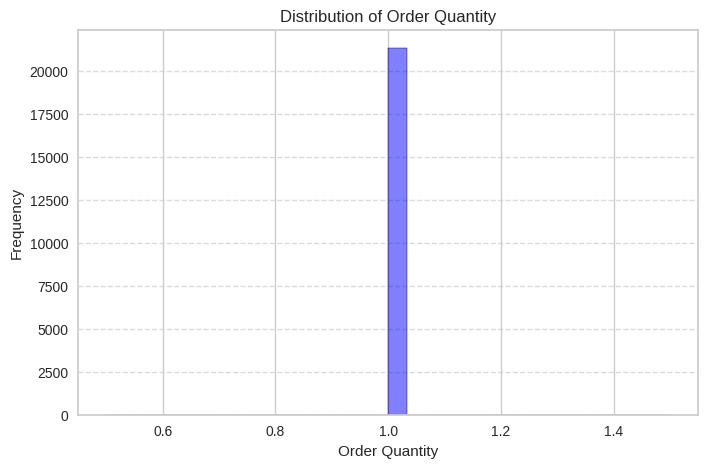

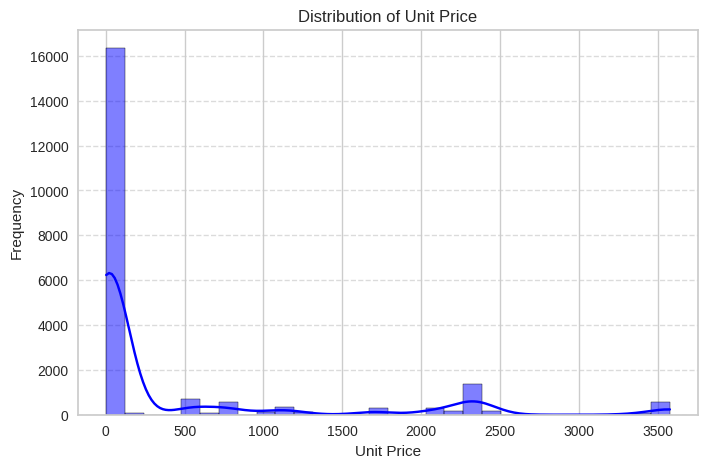

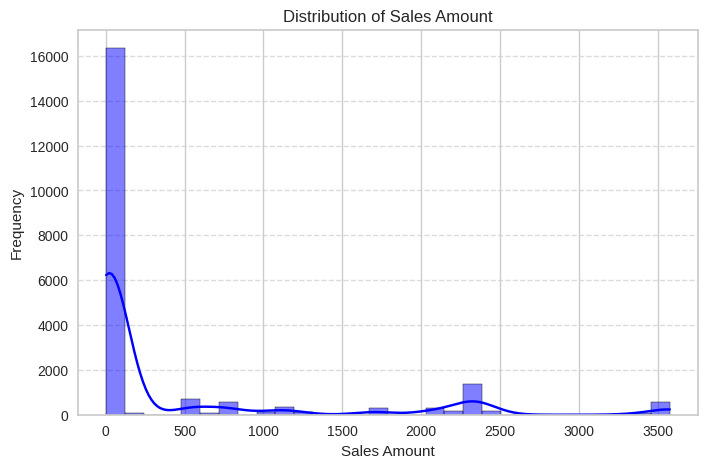

In [ ]:
# Distribution plots for numerical columns
numerical_columns = ['Order Quantity', 'Unit Price', 'Sales Amount']
for col in numerical_columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(sales_data[col], kde=True, bins=30, color='blue')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

An interesting observation is the slight increase in the frequency of transactions within the **2000 USD - 2500 USD range**. This suggests that there is **a notable segment** of higher-value transactions that could be worth exploring. These may represent either **premium products or special promotions**, which contribute to this peak.

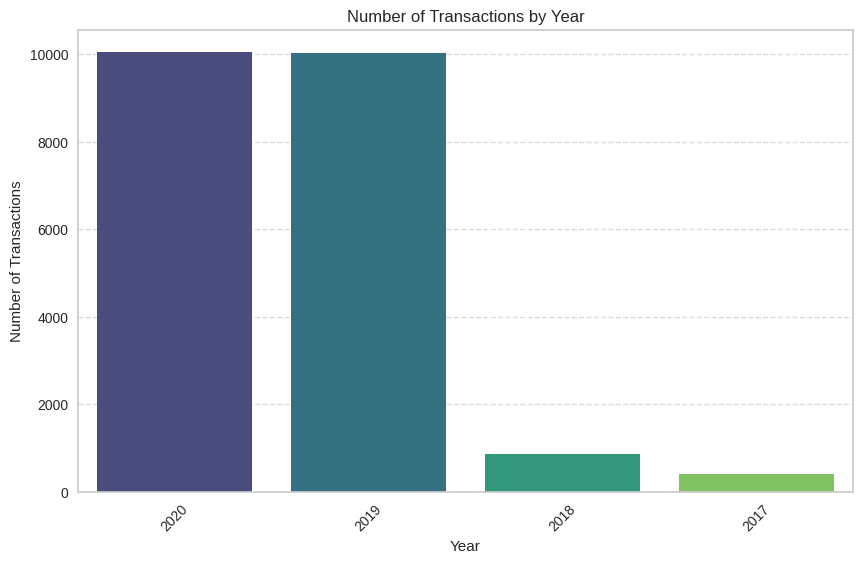

In [ ]:
# Count plot for Year
plt.figure(figsize=(10, 6))
sns.countplot(data=sales_data, x='Year', palette='viridis', order=sales_data['Year'].value_counts().index)
plt.title("Number of Transactions by Year")
plt.xlabel("Year")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**1. Shifting from Resellers to Individual Customers (DTC):**
- So, if we remember from earlier, **I removed reseller transactions (where CustomerKey = -1)** to focus just on individual customers. That’s **why we see the lower transaction counts in 2017 and 2018** — they were mostly reseller transactions that we filtered out.
- But then, **2019 and 2020** show a big shift to **individual customers**, meaning that the business likely increased its focus on DTC sales. It’s cool to see how things turned around, and I’m curious about what specifically caused this shift.

**2. Could COVID-19 Have Played a Role?:**
- Looking at **2020**, **the number of individual customer transactions really jumps**. Because of COVID, it's possible that more consumers were pushed toward **online shopping**, which benefited DTC sales.
- The big jump could also be a result of the company’s strategy to focus on direct sales during this period. It’s interesting to think if it was more of an **external factor** or **a shift in business strategy** or **customer trends** that caused this increase.

**3. 2017 and 2018: Why So Few Transactions from Individuals?:**
- As mentioned, 2017 and 2018 show fewer transactions overall because they were mostly from resellers. But I’m wondering why the company was so dependent on resellers during those years. Maybe there was more **focus on wholesale channels** or **the individual customer base wasn’t as developed at that time**.
- It’s something to look into because understanding **why resellers dominated back then could provide insights into how business strategies have evolved**.

**4. Opportunity in 2019-2020 for DTC Strategy:**
- With the rise of individual customers in 2019 and 2020, there’s a lot of **potential for the company to further optimize DTC sales**.
- It might be worth exploring **which product categories** or **customer segments** were driving this change and how the company could **enhance customer experience to continue capitalizing on DTC**.

**5. Looking Ahead:**
- If this shift to individual customers continues, it could be a great opportunity to increase profit margins by **reducing reliance on resellers**.
- We should keep an eye on **trends for 2021 and beyond** to see if this growth in DTC continues or if the market shifts again.

In [ ]:
print(sales_data['OrderDateKey'].max())
print(sales_data['OrderDateKey'].min())

2020-06-15 00:00:00
2017-07-01 00:00:00


The dataset spans from July 1st, 2017 to June 15th, 2020, covering nearly 3 years of transaction data.
- 2017 only includes the second half of the year.

- 2020 stops in mid-June, so it doesn’t represent a full year.

I defined a **time scope** for the analysis from **July 1, 2017** to the latest transaction date in the dataset, which is **June 15, 2020**.

This ensures that the data used in upcoming steps is consistent and falls within a specific, well-defined period.

In [ ]:
# Define the time scope: from 2017/07/01 to the latest date in the data
start_date = pd.to_datetime('2017/07/01')
end_date = sales_data['OrderDateKey'].max()  # Latest date in the dataset

# Filter the data for the defined time scope
sales_data = sales_data[(sales_data['OrderDateKey'] >= start_date) & (sales_data['OrderDateKey'] <= end_date)]

# Output the time scope for confirmation
print("Time Scope for Analysis:")
print(f"Start Date: {start_date.strftime('%Y-%m-%d')}")
print(f"End Date: {end_date.strftime('%Y-%m-%d')}")
print(f"Number of Transactions in this Time Scope: {sales_data.shape[0]}")


Time Scope for Analysis:
Start Date: 2017-07-01
End Date: 2020-06-15
Number of Transactions in this Time Scope: 21344


I created a new cleaned dataset by resetting the index. This ensures a tidy DataFrame with sequential indexing, which is helpful after filtering rows and preparing for further analysis.

In [ ]:
# Create a new dataset with reset index
cleaned_sales_data = sales_data.reset_index(drop=True)

I added a new column called YearMonth to represent the date in a Year-Month format (e.g., "2019-07"). This is useful for monthly trend analysis and time series visualizations.

In [ ]:
# Add YearMonth column
cleaned_sales_data['YearMonth'] = cleaned_sales_data['OrderDateKey'].dt.to_period('M').astype(str)

I created a **summary table (customer_summary)** that shows **the first and last purchase dates** for each customer. This helps analyze the **customer activity span** and is useful for analyzing purchasing patterns over time.

In [ ]:
# The first purchase date and the last purchase date
customer_summary = cleaned_sales_data.groupby('CustomerKey')['OrderDateKey'].agg(['min', 'max']).reset_index()
customer_summary.columns = ['CustomerKey', 'FirstPurchaseDate', 'LastPurchaseDate']

Let's see customer_summary table

In [ ]:
customer_summary.head()

,CustomerKey,FirstPurchaseDate,LastPurchaseDate
0,11012,2019-08-17,2020-03-17
1,11013,2019-09-14,2020-06-12
2,11014,2019-08-24,2019-10-01
3,11015,2019-06-21,2019-06-21
4,11016,2019-07-13,2019-07-13


## Cleaned Dataset

In [ ]:
# Display the first few rows of the cleaned dataset
print(cleaned_sales_data.shape)

print("\nCleaned dataset sample:")
cleaned_sales_data.head()

(21344, 12)

Cleaned dataset sample:


,Sales Order,CustomerKey,OrderDateKey,Order Quantity,Unit Price,Sales Amount,Year,Country-Region,State-Province,ProductKey,Category,YearMonth
0,SO43699,25863,2017-07-01,1,3399.9900,3399.9900,2017,United States,Oregon,346,Bikes,2017-07
1,SO43700,14501,2017-07-01,1,699.0982,699.0982,2017,United States,California,336,Bikes,2017-07
2,SO43702,27645,2017-07-01,1,3578.2700,3578.2700,2017,United States,California,311,Bikes,2017-07
3,SO43706,27621,2017-07-02,1,3578.2700,3578.2700,2017,United States,California,312,Bikes,2017-07
4,SO43707,27616,2017-07-02,1,3578.2700,3578.2700,2017,United States,California,312,Bikes,2017-07


To analyze sales trends, I’ll create a bar plot showing revenue by category (Bikes, Accessories, Parts). The goal is to:
- **Compare revenue** across product categories.
- **Observe trends** in sales over the years.
- **Identify top-performing categories**.

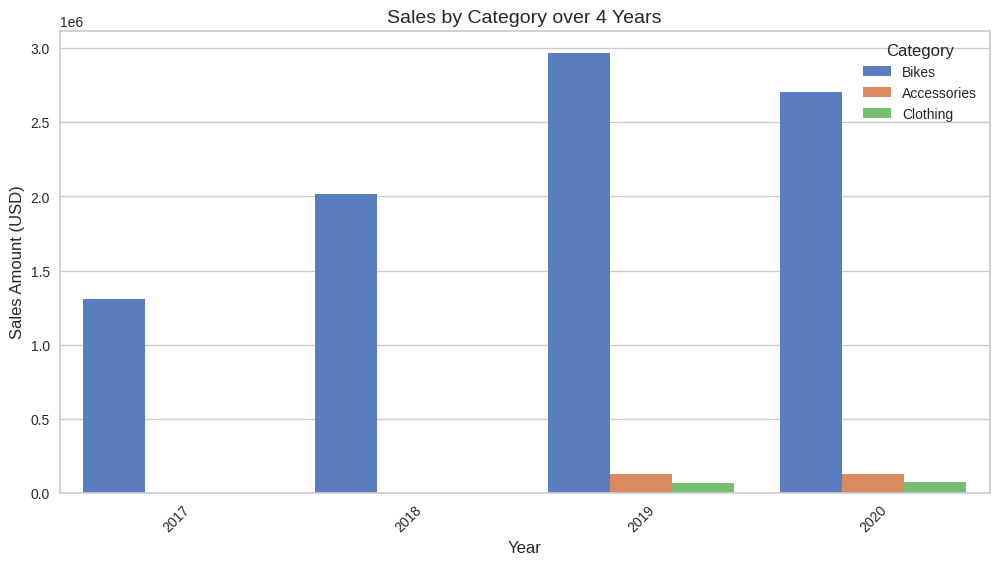

In [ ]:
# Group by category and year, then sum the sales amount
category_sales = cleaned_sales_data.groupby(['Category', 'Year'])['Sales Amount'].sum().reset_index()

# Create a bar plot for sales by category and year
plt.figure(figsize=(12, 6))
sns.barplot(x='Year', y='Sales Amount', hue='Category', data=category_sales, palette='muted')

# Title and labels
plt.title('Sales by Category over 4 Years', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Sales Amount (USD)', fontsize=12)

# Show the plot
plt.xticks(rotation=45)
plt.show()

- Bikes dominate the sales revenue.
- Accessories and Clothing have very low sales revenue compared to Bikes across all years.
- No sales from "Accessories" and "Clothing" between mid-2017 and end of 2018.
- In 2019 and 2020, there’s a slight growth in Accessories and Clothing sales.

In next step, I summarize the **sales data by region (State-Province)** to understand the distribution of sales across different areas:
- Group data by State-Province and calculate the total sales for each region.
- Filter the regions to display only those with sales greater than 0.
- Sort the regions by sales amount in descending order to identify the highest-performing areas.

This analysis helps in understanding **where the most sales are coming from** and can provide insights into potential areas to target for growth.

In [ ]:
# Group data by State-Province and calculate total Sales Amount
state_sales = cleaned_sales_data.groupby('State-Province')['Sales Amount'].sum().reset_index()

# Filter out regions with Sales Amount greater than 0
state_sales_filtered = state_sales[state_sales['Sales Amount'] > 0]

# Sort by Sales Amount in descending order
state_sales_filtered = state_sales_filtered.sort_values(by='Sales Amount', ascending=False)

# Display the sales by region table
print(state_sales_filtered)

    State-Province  Sales Amount
2       California  5.714258e+06
20      Washington  2.467248e+06
15          Oregon  1.170992e+06
3          Florida  7.760910e+03
21         Wyoming  7.115010e+03
18            Utah  4.419580e+03
12        New York  4.124190e+03
5         Illinois  2.828090e+03
16  South Carolina  2.434920e+03
1          Arizona  2.104020e+03
7    Massachusetts  2.049098e+03
17           Texas  1.789100e+03
4          Georgia  1.658920e+03
14            Ohio  3.591800e+02
6         Kentucky  2.169600e+02
11         Montana  9.208000e+01
8        Minnesota  9.128000e+01
9      Mississippi  8.259000e+01
10        Missouri  8.146000e+01
19        Virginia  3.998000e+01
0          Alabama  3.729000e+01
13  North Carolina  7.280000e+00


- **California has the highest sales**, reaching 5.71 million USD.
- Washington and Oregon follow with 2.47 million USD and 1.17 million USD, respectively.
- Florida and several other states have significantly lower sales, ranging from a few thousand to a few hundred USD.
- Alabama and North Carolina show very low sales, under 100 USD.

## Customer Retention and Sales Trend Analysis

In this step, I analyzed how many unique purchases each customer made. Based on that, I grouped them into 2 groups. It gives a quick idea of customer retention in the dataset. Here’s what I did in this step:
1. Count purchases per customer: I used **nunique()** to count how many **unique sales orders** each customer made.

2. Classify customers
- If they **bought once**, they’re labeled **"One-Time"**
- If they bought **multiple times**, they’re **"Returning"**
3. Calculate percentages: I counted how many customers are in each group and divided by the total number of customers to get the percentage.


In [ ]:
# Count the number of transactions for each customer
purchase_counts = cleaned_sales_data.groupby('CustomerKey')['Sales Order'].nunique().reset_index()
purchase_counts.columns = ['CustomerKey', 'PurchaseCount']

# Classify customers as One-Time or Returning
purchase_counts['CustomerType'] = purchase_counts['PurchaseCount'].apply(
    lambda x: 'One-Time' if x == 1 else 'Returning'
)

# Calculate the percentage of each customer type
customer_percentage = purchase_counts['CustomerType'].value_counts(normalize=True) * 100
print("Customer Percentage:")
print(customer_percentage)

Customer Percentage:
CustomerType
One-Time     77.772094
Returning    22.227906
Name: proportion, dtype: float64


The results show:
- **77.8%** of customers made only one purchase
- Only **22.2%** came back for additional orders

At first glance, this might seem like low retention. However, it’s worth noting that the dataset includes **not only bicycles** (which are **high-value** and typically **purchased infrequently**) but also **accessories and components**, which may have a shorter repurchase cycle.

This makes it important to further segment the dataset by **product category** to understand:
- Are customers buying bikes, accessories, or both?
- Are one-time buyers mostly purchasing bikes or smaller items?
- Do returning customers tend to buy upgrades, accessories, or maintenance products?
- Which product types have higher repeat purchase behavior?

This analysis could reveal which product groups are better at driving retention — and help shape different strategies for each segment (e.g., loyalty campaigns for accessories, upsell flows for bike buyers).

To better understand how revenue is generated over time, I decided to break down monthly sales by customer type — distinguishing between **One-Time** and **Returning** customers. Here’s my approach:

- **Merge Customer Type into the Sales Data**: I merged the customer segmentation results (one-time vs. returning) back into the original sales data to label each transaction accordingly.

- **Group by Month and Customer Type**: Using the *YearMonth* column, I aggregated total sales for each customer type in each month.
This helps visualize revenue patterns, such as:
 - Are returning customers becoming more valuable over time?
 - Do one-time customers dominate in certain months?

This step sets the foundation for plotting a time-series trend that reveals how customer loyalty and revenue contribution evolve over the 3-year period.

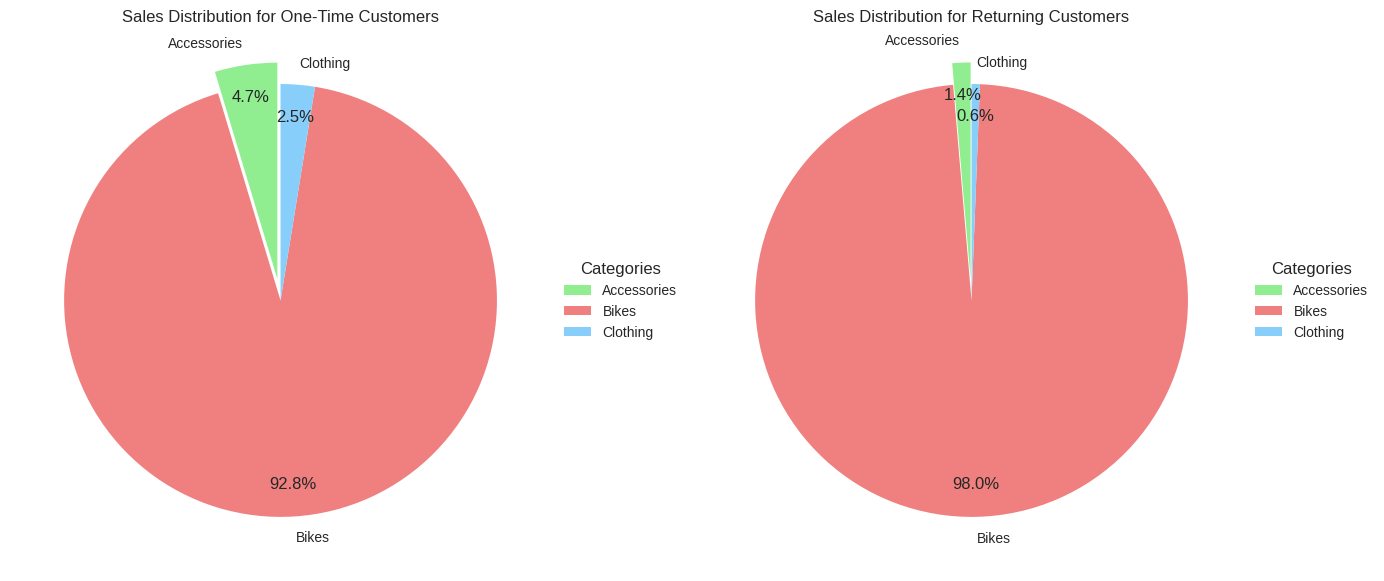

In [ ]:
# Create pie charts for One-Time and Returning customers
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# One-Time Pie Chart
one_time_data = category_by_type[category_by_type['CustomerType'] == 'One-Time']
explode = (0.1, 0, 0)  # Slightly "explode" the first segment (Bikes)
axes[0].pie(one_time_data['Sales Amount'],
            labels=one_time_data['Category'],
            autopct='%1.1f%%',
            startangle=90,
            explode=explode,
            colors=['lightgreen', 'lightcoral', 'lightskyblue'],
            pctdistance=0.85)  # Adjust percentage position
axes[0].set_title('Sales Distribution for One-Time Customers')
axes[0].legend(one_time_data['Category'], loc='center left', bbox_to_anchor=(1, 0.5), title="Categories")

# Returning Pie Chart
returning_data = category_by_type[category_by_type['CustomerType'] == 'Returning']
axes[1].pie(returning_data['Sales Amount'],
            labels=returning_data['Category'],
            autopct='%1.1f%%',
            startangle=90,
            explode=explode,
            colors=['lightgreen', 'lightcoral', 'lightskyblue'],
            pctdistance=0.85)  # Adjust percentage position
axes[1].set_title('Sales Distribution for Returning Customers')
axes[1].legend(returning_data['Category'], loc='center left', bbox_to_anchor=(1, 0.5), title="Categories")

plt.tight_layout()  # Adjust layout to avoid elements being cut off
plt.show()

**Bikes are the main product** for both One-Time and Returning customers, with **over 90% of sales**. However, **Accessories and Clothing**, which probably started **being sold online via DTC from 2019**, make up about **7.7%** of One-Time customer sales, showing potential for growth in these categories. For Returning customers, Accessories and Clothing account for around **2.5%**, indicating some interest. Overall, Bikes remain the dominant product.

In [ ]:
# Merge the original data with customer type:
merged_data = cleaned_sales_data.merge(
    purchase_counts[['CustomerKey', 'CustomerType']],
    on='CustomerKey'
)

# Calculate total sales by month and customer type
monthly_sales = merged_data.groupby(['YearMonth', 'CustomerType'])['Sales Amount'].sum().reset_index()

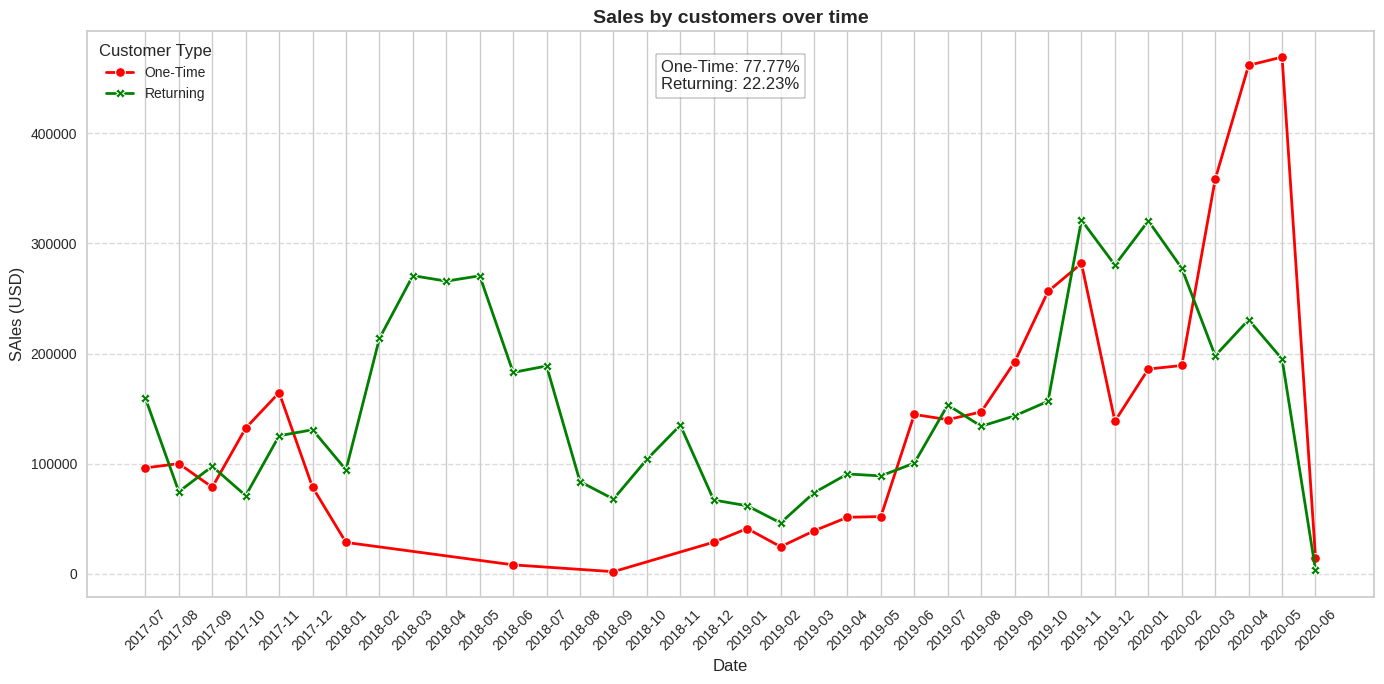

In [ ]:
# Plot Sales by Customer Type Over Time
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=monthly_sales,
    x='YearMonth',
    y='Sales Amount',
    hue='CustomerType',
    style='CustomerType',
    markers=True,
    dashes=False,
    linewidth=2,
    palette={'One-Time': 'red', 'Returning': 'green'}
)

# Chart formatting
plt.title('Sales by customers over time', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('SAles (USD)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Customer Type', title_fontsize=12, fontsize=10)

# Display Customer Percentage on the Plot
plt.text(
    x=0.5,
    y=0.95,
    s=f'One-Time: {customer_percentage["One-Time"]:.2f}%\nReturning: {customer_percentage["Returning"]:.2f}%',
    transform=plt.gca().transAxes,
    ha='center',
    va='top',
    bbox=dict(facecolor='white', alpha=0.8)
)

plt.tight_layout()
plt.show()

The chart highlights some key observations:

- While **One-Time** customers make up the majority (77.77%), **Returning** customers generated more revenue during several periods — especially between 2018 and 2019.
- From late **2019 to 2020**, **sales from One-Time customers spiked significantly**. This aligns with previous findings where DTC (individual customer) transactions increased sharply in 2019–2020, possibly pointing to a **segment of new potential customers**.
- Still, **Returning customers contribute to more stable long-term revenue**.

Additionally, the current classification considers a customer "returning" if they have made two or more purchases — but **does not consider the time factor**. Some of these customers may have returned a long time ago and have been inactive since. Thus, it’s important to apply **RFM analysis** (Recency, Frequency, Monetary) for deeper behavioral insights.

## Retention Rate Visualization

In this step, I prepare the dataset for **Cohort Analysis**, which helps track customer behavior based on the **month of their first purchase**.

Here's what's happening:
- I create a CohortMonth column that stores the first purchase month for each customer.
- I extract the month of each transaction into a TransactionMonth column.
- I calculate CohortIndex, which measures how many months have passed between a customer's first purchase and each subsequent purchase.

This sets the foundation to understand **customer retention over time** and identify how long customers stay active after their first transaction.

In [ ]:
# Get the first month of purchase for each customer
cleaned_sales_data['CohortMonth'] = cleaned_sales_data.groupby('CustomerKey')['OrderDateKey'].transform('min').dt.to_period('M')

# Get the transaction month for each purchase
cleaned_sales_data['TransactionMonth'] = cleaned_sales_data['OrderDateKey'].dt.to_period('M')

# Calculate the number of months between the transaction month and the first purchase month
cleaned_sales_data['CohortIndex'] = (cleaned_sales_data['TransactionMonth'].astype(int) - cleaned_sales_data['CohortMonth'].astype(int))

# Check the data
print(cleaned_sales_data[['CustomerKey', 'CohortMonth', 'TransactionMonth', 'CohortIndex']].head())


   CustomerKey CohortMonth TransactionMonth  CohortIndex
0        25863     2017-07          2017-07            0
1        14501     2017-07          2017-07            0
2        27645     2017-07          2017-07            0
3        27621     2017-07          2017-07            0
4        27616     2017-07          2017-07            0


In this step, I build a **Cohort Retention Table** to track how many customers return after their first purchase month:
- First, I count the number of **unique customers** per cohort (CohortMonth) and per time offset (CohortIndex).
- Then, I **pivot** the data into a matrix format: rows represent the cohort start month, and columns represent how many months have passed since.
- Finally, I compute the **Retention Rate** by dividing each value by the number of customers in the first column (month 0 of each cohort).

This produces a clear view of how well we retain customers over time, cohort by cohort.

In [ ]:
# Count unique customers in each Cohort by CohortIndex
cohort_counts = cleaned_sales_data.groupby(['CohortMonth', 'CohortIndex'])['CustomerKey'].nunique().reset_index()

# Create a pivot table to display the data in the form of a Cohort Table matrix
cohort_pivot = cohort_counts.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerKey')

# Calculate the Retention Rate by dividing by the initial number of customers in each Cohort
cohort_retention = cohort_pivot.divide(cohort_pivot.iloc[:, 0], axis=0)

# Check the data
print(cohort_retention.head())

CohortIndex   0   1   2   3   4   5   6   7   8   9   ...        25        26  \
CohortMonth                                           ...                       
2017-07      1.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...       NaN       NaN   
2017-08      1.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...       NaN       NaN   
2017-09      1.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...       NaN  0.071429   
2017-10      1.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  0.016129  0.129032   
2017-11      1.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  0.089888  0.089888   

CohortIndex        27        28        29        30        31        32  \
CohortMonth                                                               
2017-07           NaN  0.087500  0.087500  0.037500       NaN  0.012500   
2017-08      0.018519  0.111111  0.092593       NaN       NaN  0.037037   
2017-09      0.142857  0.017857  0.017857       NaN       NaN  0.339286   
2017-10           NaN  0.080645  0.016129  0.016129  0.01

This code calculates cohort analysis by determining the first purchase month for each customer, extracting the transaction month for each purchase, and calculating the CohortIndex, which represents the number of months since the first purchase. This is useful for analyzing customer behavior over time.

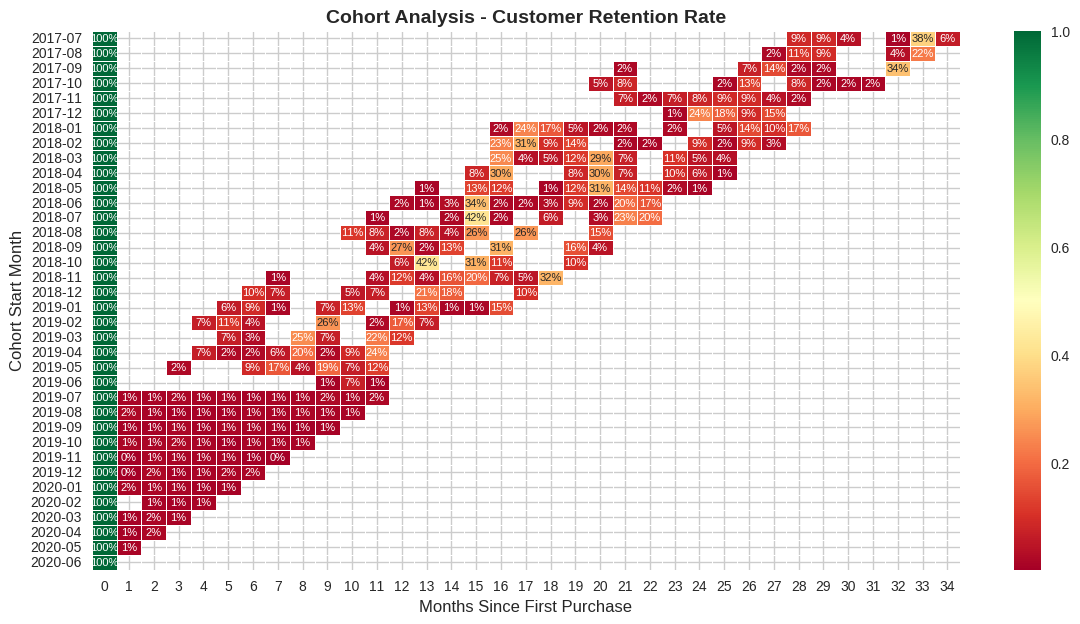

In [ ]:
plt.figure(figsize=(14, 7))
sns.heatmap(
    cohort_retention,
    annot=True,
    fmt=".0%",
    cmap="RdYlGn",
    linewidths=0.5,
    annot_kws={"size": 8}  # Giảm kích thước font chữ tại đây
)

# Chart formatting
plt.title('Cohort Analysis - Customer Retention Rate', fontsize=14, fontweight='bold')
plt.xlabel('Months Since First Purchase', fontsize=12)
plt.ylabel('Cohort Start Month', fontsize=12)
plt.yticks(rotation=0)

plt.show()

The heatmap provides insights into customer retention rates for bicycles and accessories, which are non-essential, long-lasting products.

**1. Initial Retention:**

- Customers who made their first purchase of bicycles earlier (in 2017-2018) show a higher retention rate in the following months. This could reflect initial interest or promotional campaigns that encouraged repeat purchases early on.
- However, as time progresses (especially in later cohorts), there is a decline in retention, which is typical for non-essential items like bicycles, as they are long-lasting products and do not require frequent repurchasing.

**2. Drop-off Over Time:**

- Given the **nature of bicycles being durable products**, it’s expected that customers will not return frequently. After the initial purchase, many customers may not buy another bicycle for several years, leading to the sharp drop-off in retention beyond the first few months.
The early retention might indicate interest in accessories or related products, which could be leveraged for upselling or cross-selling opportunities.

- Cohort Analysis Insights: The newer cohorts (2020 and later) show lower retention, which could indicate that customer engagement strategies may need improvement to keep customers interested in the long term.
A potential reason for this could be that once customers buy a bicycle, they may not have a need for another one in the short term. This suggests that businesses should focus on customer engagement beyond the initial purchase, such as offering bicycle maintenance, accessories, or loyalty programs to keep them coming back.

**3. Business Insights for Bicycle Products:**

- Focus on Customer Loyalty: While many customers may not need a second bicycle soon, businesses should find ways to engage them through maintenance services, accessories, or promotions for future purchases.
- Seasonal and Usage-Based Engagement: As bicycles are long-term products, engagement efforts should be more seasonal (e.g., during spring/summer months) or based on the usage cycle of the product (e.g., after a year of use).
Retention Strategies for Non-Essential Products: With non-essential products like bicycles, targeted retention efforts such as offering product upgrades, bike accessories, or related services (like repairs or warranties) can help maintain customer interest.

# **Step 3: Calculate RFM Metrics**



### Group data by Sales Order to prepare for RFM analysis

In [ ]:
aggregated_sales_data = cleaned_sales_data.groupby('Sales Order').agg(
    CustomerKey=('CustomerKey', 'first'),
    OrderDateKey=('OrderDateKey', 'first'),
    Sales_Amount=('Sales Amount', 'sum')
).reset_index()

### Define Metrics
Calculate Recency, Frequency, and Monetary values.

In [ ]:
reference_date = aggregated_sales_data['OrderDateKey'].max()
rfm = aggregated_sales_data.groupby('CustomerKey').agg(
    Recency=('OrderDateKey', lambda x: (reference_date - x.max()).days),
    Frequency=('Sales Order', 'count'),
    Monetary=('Sales_Amount', 'sum')
).reset_index()

In [ ]:
# Set CustomerKey as the index
rfm.set_index('CustomerKey', inplace=True)

#View sample RFM dataset
rfm.head(10)

,Recency,Frequency,Monetary
CustomerKey,,,
11012,90,2,81.26
11013,3,2,113.96
11014,258,2,138.45
11015,360,1,2500.97
11016,338,1,2332.28
11021,355,1,2371.96
11022,358,1,2322.28
11023,7,2,122.24
11024,171,2,56.51


In [ ]:
# Filter sales data for CustomerKey 11012
#customer_11014_orders = cleaned_sales_data[cleaned_sales_data['CustomerKey'] == 11014]

# Extract the distinct Sales Orders for this customer
#distinct_sales_orders = customer_11014_orders['Sales Order'].unique()

# Print the Sales Orders
#print("Sales Orders for CustomerKey 11014:")
#print(distinct_sales_orders)

## Check Distribution of RFM Variables
Perform statistical analysis and visualize key data insights.


In [ ]:
rfm.describe()

,Recency,Frequency,Monetary
count,7819.000000,7819.000000,7819.000000
mean,189.318967,1.223558,1200.893914
std,165.182035,0.419714,1680.927491
min,0.000000,1.000000,2.290000
25%,77.000000,1.000000,39.980000
50%,165.000000,1.000000,123.980000
75%,261.000000,1.000000,2071.419600
max,1078.000000,3.000000,6770.600000


The average last purchased date is 18 days ago with nearly 1.2 purchases and 1200.9 revenue in total.

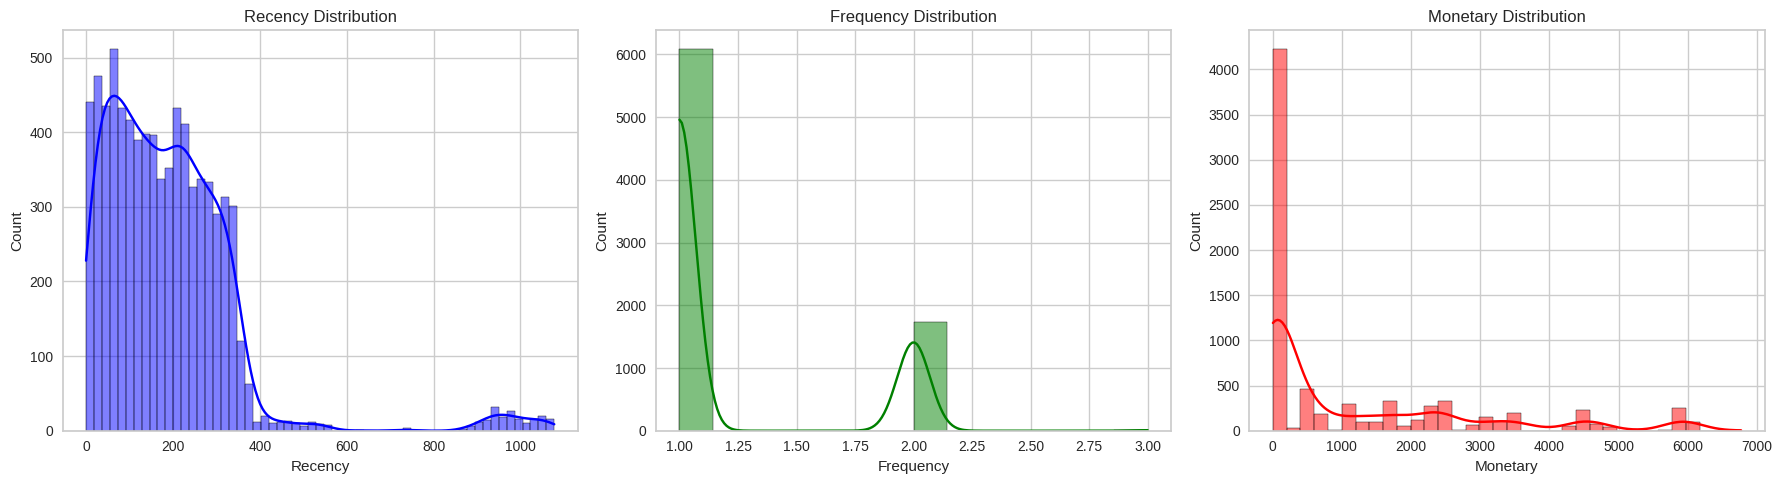

In [ ]:
# Visualize Distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(rfm['Recency'], kde=True, ax=axes[0], color='blue').set_title('Recency Distribution')
sns.histplot(rfm['Frequency'], kde=True, ax=axes[1], color='green').set_title('Frequency Distribution')
sns.histplot(rfm['Monetary'], kde=True, ax=axes[2], color='red').set_title('Monetary Distribution')
plt.tight_layout()
plt.show()

Text(0.5, 0, 'Attributes')

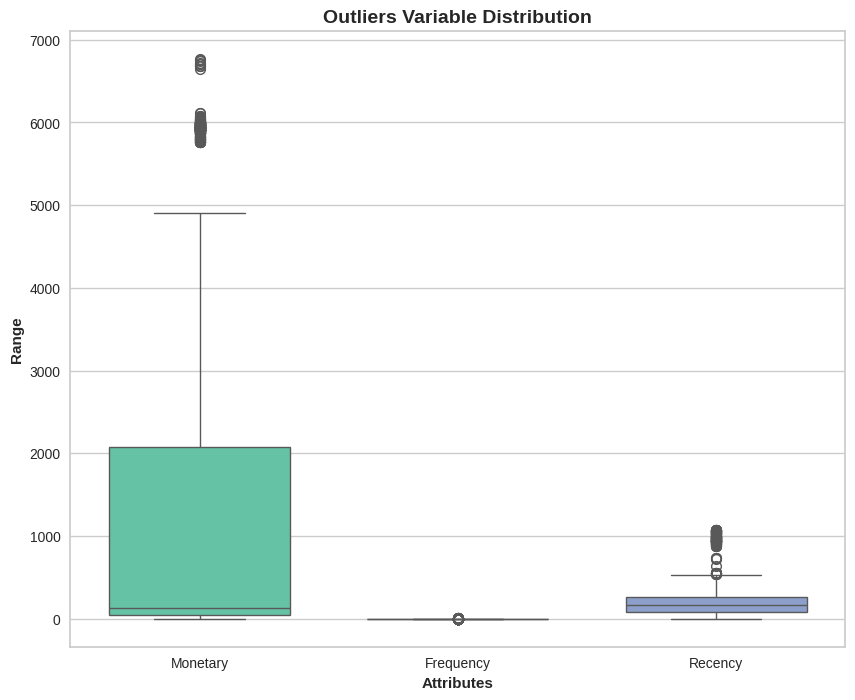

In [ ]:
# Outlier Analysis of Monetary, Frequency and Recency

attributes = ['Monetary','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

- Customer Behavior: The data shows that most customers have made only one or two recent transactions, suggesting that engagement strategies should focus on turning occasional buyers into repeat customers.
- High-Value Customers: There is a small group of high-value customers contributing significantly to revenue, and it's important to identify and retain these customers.
- Improving Engagement: Given the skewed distributions, businesses can improve customer retention through targeted efforts, focusing on both frequent buyers and those with high spending.

## RFM Analysis
Customers with the most recent transactions receive a R score of 1, while those with the least recent transactions get a R score of 4, as recent buyers are more valuable to the business. The same method is used for Frequency and Monetary scores, but in reverse: the highest frequency and monetary values get a score of 4, and the lowest get a score of 1. The overall RFM score reflects customer value. Customers with an RFM score of 111 are the worst valuable, while those with an RFM score of 444 are the most valuable to the company.

In [ ]:
rfm['RScore']=pd.qcut(rfm['Recency'],4,labels=[4,3,2,1])
rfm['FScore']=pd.qcut(rfm['Frequency'].rank(method='first'),4,labels=[1,2,3,4])
rfm['MScore']=pd.qcut(rfm['Monetary'],4,labels=[1,2,3,4])
rfm.head()

,Recency,Frequency,Monetary,RScore,FScore,MScore
CustomerKey,,,,,,
11012,90,2,81.26,3,4,2
11013,3,2,113.96,4,4,2
11014,258,2,138.45,2,4,3
11015,360,1,2500.97,1,1,4
11016,338,1,2332.28,1,1,4


In [ ]:
rfm['RFM_Score'] = rfm['RScore'].astype(str) + rfm['FScore'].astype(str) + rfm['MScore'].astype(str)
rfm.head()

,Recency,Frequency,Monetary,RScore,FScore,MScore,RFM_Score
CustomerKey,,,,,,,
11012,90,2,81.26,3,4,2,342
11013,3,2,113.96,4,4,2,442
11014,258,2,138.45,2,4,3,243
11015,360,1,2500.97,1,1,4,114
11016,338,1,2332.28,1,1,4,114


In [ ]:
# Function to segment customers based on RFM Score
def segment_customer(rfm_score):
    R, F, M = int(rfm_score[0]), int(rfm_score[1]), int(rfm_score[2])  # Convert RFM score to integers

    # Top Customers: Best customers across all RFM factors
    if R == 4 and F == 4 and M == 4:
        return 'Top Customers'

    # Active Customers: Regular buyers, good spending
    elif R >= 2 and F >= 3 and M >= 3:
        return 'Active Customers'

    # Emerging Customers: Recently acquired and showing potential
    elif R >= 3 and F >= 1 and M >= 2:
        return 'Emerging Customers'

    # Unsteady Customers: Unsteady but with potential
    elif R >= 2 and F >= 1 and M >= 2:
        return 'Unsteady Customers'

    # At-Risk Customers: Previously frequent buyers and high spending but now inactive
    elif R <= 2 and F >= 2 and M >= 2:
        return 'At-Risk Customers'

    # Potential Lost Customers: Low recent activity, moderate frequency & spending
    elif R <= 2 and F <= 2 and M <= 2:
        return 'Potential Lost Customers'

    # Inactive Customers: Low recency, still some activity
    elif R <= 2 and F >= 2 and M >= 2:
        return 'Inactive Customers'

    # Lost Customers: Completely churned customers
    else:
        return 'Lost Customers'

# Apply segmentation
rfm['Segment'] = rfm['RFM_Score'].apply(segment_customer)

# Count customers in each segment
customer_segments = rfm['Segment'].value_counts(normalize=True) * 100

# Display segment distribution
print(customer_segments)

Segment
Emerging Customers          24.542780
Lost Customers              19.618877
Active Customers            17.572580
At-Risk Customers           15.475125
Unsteady Customers          11.356951
Potential Lost Customers     8.939762
Top Customers                2.493925
Name: proportion, dtype: float64


In [ ]:
rfm.head(50)

,Recency,Frequency,Monetary,RScore,FScore,MScore,RFM_Score,Segment
CustomerKey,,,,,,,,
11012,90,2,81.26,3,4,2,342,Emerging Customers
11013,3,2,113.96,4,4,2,442,Emerging Customers
11014,258,2,138.45,2,4,3,243,Active Customers
11015,360,1,2500.97,1,1,4,114,Lost Customers
11016,338,1,2332.28,1,1,4,114,Lost Customers
11021,355,1,2371.96,1,1,4,114,Lost Customers
11022,358,1,2322.28,1,1,4,114,Lost Customers
11023,7,2,122.24,4,4,2,442,Emerging Customers
11024,171,2,56.51,2,4,2,242,Unsteady Customers


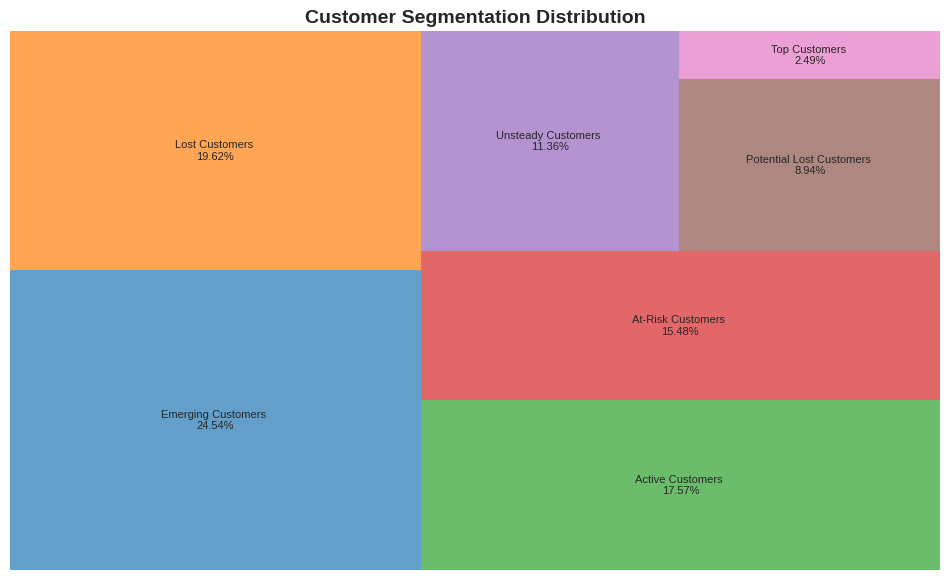

In [ ]:
# Create treemap
plt.figure(figsize=(12, 7))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
squarify.plot(
    sizes=customer_segments.values,
    label=[f"{seg} \n{round(pct, 2)}%" for seg, pct in customer_segments.items()],
    color=colors,
    alpha=0.7,
    text_kwargs={'fontsize': 8}
)

# Chart formatting
plt.axis('off')
plt.title("Customer Segmentation Distribution", fontsize=14, fontweight="bold")
plt.show()


/tmp/ipython-input-352-868310510.py:4: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



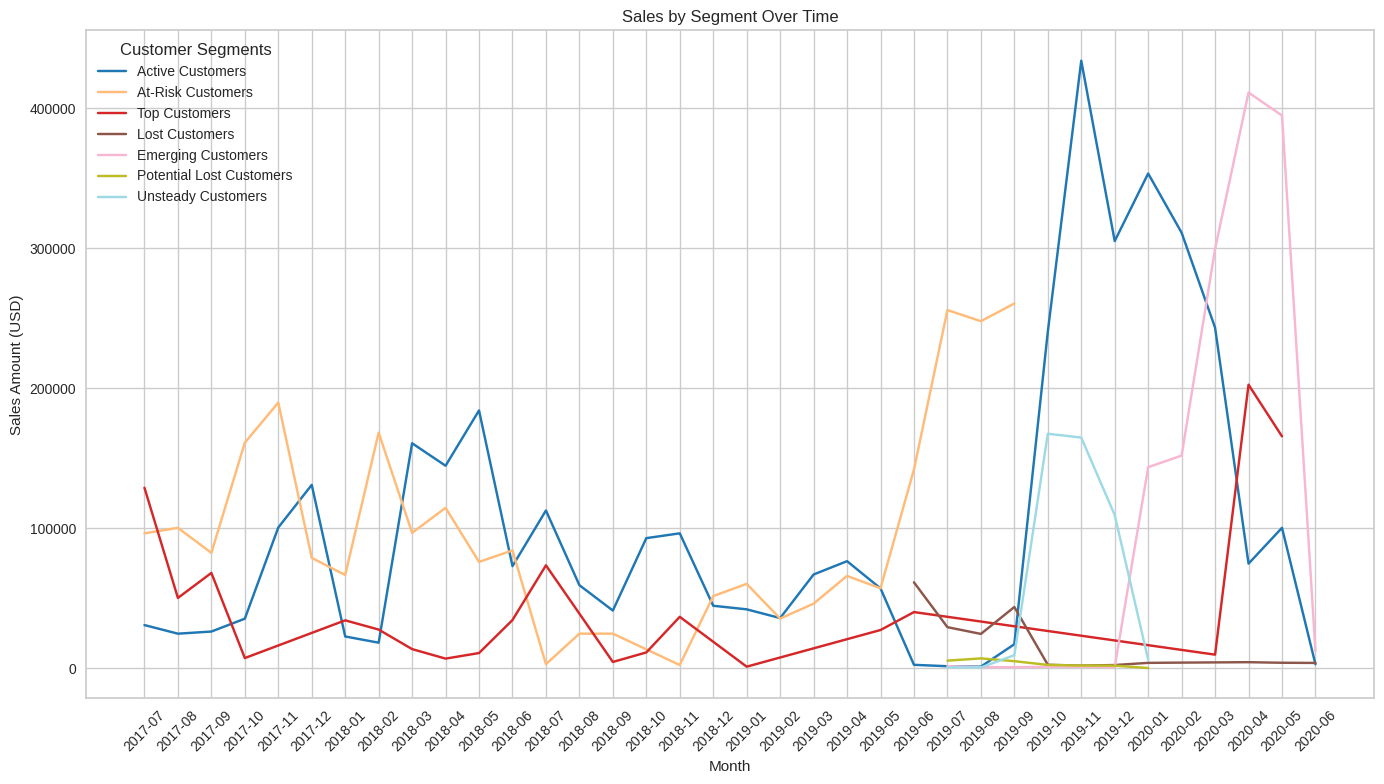

In [ ]:
import matplotlib.cm as cm

# Generate a color map with as many colors as there are segments
color_map = cm.get_cmap('tab20', len(sales_by_segment['Segment'].unique()))

# Reset the index to make CustomerKey a column in the rfm dataframe
rfm_reset = rfm.reset_index()

# Merge the sales data with the RFM segments
sales_data_segments = cleaned_sales_data.merge(rfm_reset[['CustomerKey', 'Segment']], on='CustomerKey', how='left')

# Group by YearMonth and Segment to get total sales per segment
sales_by_segment = sales_data_segments.groupby(['YearMonth', 'Segment'])['Sales Amount'].sum().reset_index()

# Create the line plot
plt.figure(figsize=(14, 8))
for i, segment in enumerate(sales_by_segment['Segment'].unique()):
    segment_data = sales_by_segment[sales_by_segment['Segment'] == segment]
    plt.plot(segment_data['YearMonth'].astype(str), segment_data['Sales Amount'], label=segment, color=color_map(i))

plt.title('Sales by Segment Over Time')
plt.xlabel('Month')
plt.ylabel('Sales Amount (USD)')
plt.xticks(rotation=45)
plt.legend(title='Customer Segments')
plt.grid(True)
plt.tight_layout()
plt.show()

In the line plot above, we can observe the sales distribution by different customer segments from July 2017 to June 2020. The segments include:
- **Active Customers (blue)**: These customers have regular purchases and good sales amounts. We can see a noticeable peak for this group around the end of 2019 and the beginning of 2020, suggesting that they remained consistent in purchasing during this time.
- **At-Risk Customers (orange)**: Customers who were once frequent buyers but have since become inactive show a decline, especially around the end of 2019. However, some recovery is noticeable toward 2020, which might indicate reactivation efforts or changes in customer behavior.
- **Top Customers (green)**: This group consistently accounts for a significant portion of sales, maintaining relatively high sales over time. Their curve is steady, showing that they are loyal and make frequent, large purchases.
- **Emerging Customers (brown)**: These customers, likely new buyers, see an increase in sales beginning from late 2019 to 2020, indicating successful acquisition efforts in this period.
- **Lost Customers (purple)**: This group has consistently low sales, showing that the engagement with these customers remains minimal. The curve mostly stays near the bottom.
- **Potential Lost Customers (grey)**: This segment, which could be at risk of churn, saw occasional sales in early 2019 but very few in 2020.
- **Unsteady Customers (yellow)**: The sales from this segment fluctuate significantly, showing inconsistency in purchases over time.

It’s important to note that these customer segments are categorized based on pre-set conditions for **Recency, Frequency, and Monetary scores**, and these segments were **manually** defined using simple rules. For a more precise and data-driven approach, it would be better to implement a **clustering algorithm** such as **K-means**, which can **automatically group customers** based on their purchasing behavior. This would allow for a more accurate segmentation that better reflects the actual patterns within the data rather than pre-set thresholds.

## RFM Data Standarization

In [ ]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Standardize Recency, Frequency, and Monetary columns
scaled_rfm_values = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Convert to DataFrame and retain original index
scaled_rfm = pd.DataFrame(scaled_rfm_values, columns=['Recency', 'Frequency', 'Monetary'], index=rfm.index)

# Display the first few rows
scaled_rfm.head()

,Recency,Frequency,Monetary
CustomerKey,,,
11012,-0.601308,1.850047,-0.666124
11013,-1.128034,1.850047,-0.646669
11014,0.415817,1.850047,-0.632099
11015,1.033357,-0.532677,0.773477
11016,0.900162,-0.532677,0.673116


In [ ]:
rfm.head()

,Recency,Frequency,Monetary,RScore,FScore,MScore,RFM_Score,Segment
CustomerKey,,,,,,,,
11012,90,2,81.26,3,4,2,342,Emerging Customers
11013,3,2,113.96,4,4,2,442,Emerging Customers
11014,258,2,138.45,2,4,3,243,Active Customers
11015,360,1,2500.97,1,1,4,114,Lost Customers
11016,338,1,2332.28,1,1,4,114,Lost Customers


#**Step 4 : Modeling - Customer Segmentation Using K-Means++**

## Determine the Optimal Number of Clusters (Elbow Method)
A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.

In [ ]:
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=300, n_init=20 , random_state=42)
    kmeans.fit(scaled_rfm)
    ssd.append(kmeans.inertia_)

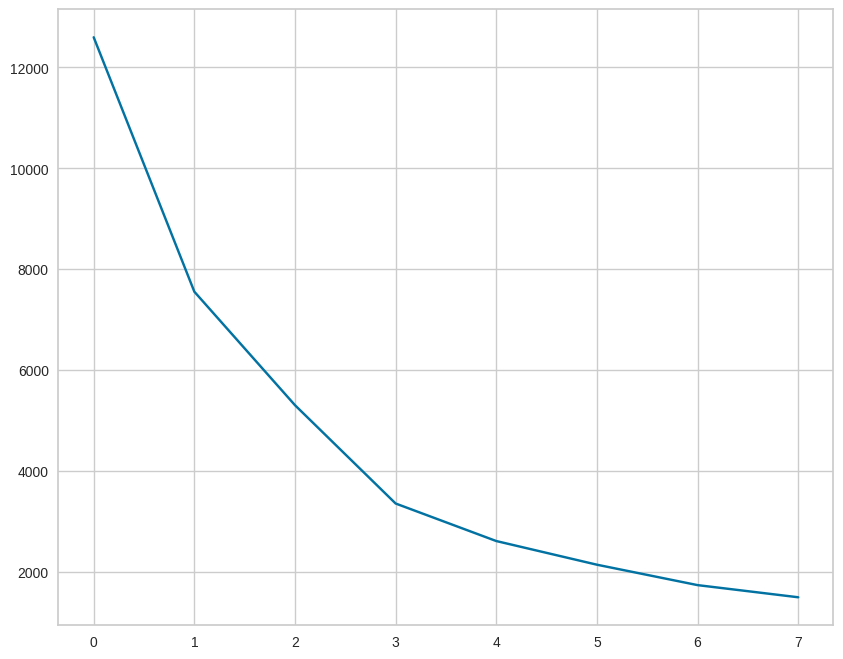

In [ ]:
# plot the SSDs for each n_clusters
plt.plot(ssd)

## Determine the Optimal Number of Clusters (Silhouette Score)
The Silhouette Score evaluates clustering quality by measuring how similar an object is to its own cluster compared to other clusters.




In [ ]:
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=300, n_init=20, random_state=42)
    kmeans.fit(scaled_rfm)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(scaled_rfm, cluster_labels)
    print(f"For n_clusters={num_clusters}, the silhouette score is {silhouette_avg}")

For n_clusters=2, the silhouette score is 0.5894948956225192
For n_clusters=3, the silhouette score is 0.6364868813671414
For n_clusters=4, the silhouette score is 0.6114102154275164
For n_clusters=5, the silhouette score is 0.48996502166923667
For n_clusters=6, the silhouette score is 0.5247956939392695
For n_clusters=7, the silhouette score is 0.5417258041912826
For n_clusters=8, the silhouette score is 0.521573144213006
For n_clusters=9, the silhouette score is 0.4945626407784729


## Apply K-Means Clustering

In [ ]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=20, random_state=42)
kmeans.fit(scaled_rfm)

KMeans(n_clusters=3, n_init=20, random_state=42)

In [ ]:
 kmeans.labels_

array([2, 2, 2, ..., 0, 1, 0], dtype=int32)

In [ ]:
# assign the label
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,Recency,Frequency,Monetary,RScore,FScore,MScore,RFM_Score,Segment,Cluster_Id
CustomerKey,,,,,,,,,
11012,90,2,81.26,3,4,2,342,Emerging Customers,2
11013,3,2,113.96,4,4,2,442,Emerging Customers,2
11014,258,2,138.45,2,4,3,243,Active Customers,2
11015,360,1,2500.97,1,1,4,114,Lost Customers,1
11016,338,1,2332.28,1,1,4,114,Lost Customers,1


In [ ]:
def split_dataframe_by_column_value(df, column_name):

    # Group by column value
    grouped = df.groupby(column_name)

    # Create a dictionary to store sub-dataframes based on column values
    subframes = {}

    # Loop through each value and create a sub-dataframe for each value
    for value, group in grouped:
        subframes[value] = group.copy()

    return subframes

cluster = split_dataframe_by_column_value(rfm, 'Cluster_Id')

# **Step 5: Evaluation & Interpretation**

## Clusters discription & Visualization

In [ ]:
cluster[0].describe()

,Recency,Frequency,Monetary,Cluster_Id
count,195.000000,195.0,195.000000,195.0
mean,974.164103,1.0,3537.689829,0.0
std,68.205524,0.0,239.879804,0.0
min,634.000000,1.0,2049.098200,0.0
25%,937.000000,1.0,3578.270000,0.0
50%,975.000000,1.0,3578.270000,0.0
75%,1028.000000,1.0,3578.270000,0.0
max,1078.000000,1.0,3578.270000,0.0


**Cluster 0 (Bronze):**

- Recency: Customers in this cluster are relatively less recent (mean: 974), with a high spread (max: 1078), suggesting they haven't purchased in a while.
- Monetary: The monetary values are high (mean: 3537), indicating that even though these customers have low frequency, their individual purchases are of significant value.
- Business Insight: These are high-value, low-frequency customers. Strategies could focus on re-engaging them, as they make substantial purchases when they do buy, possibly through targeted offers or loyalty programs.

In [ ]:
cluster[1].describe()

,Recency,Frequency,Monetary,Cluster_Id
count,5886.000000,5886.0,5886.000000,5886.0
mean,172.469589,1.0,546.740967,1.0
std,111.116527,0.0,807.452574,0.0
min,0.000000,1.0,2.290000,1.0
25%,75.000000,1.0,34.980000,1.0
50%,164.000000,1.0,71.940000,1.0
75%,260.750000,1.0,618.980000,1.0
max,555.000000,1.0,2618.620000,1.0


**Cluster 1 (Silver)**:

- Recency: Customers in this group are more recent (mean: 172), with a wide range of recency (min: 0). Some may have stopped purchasing.
- Monetary: The monetary values are moderate (mean: 547), showing a balance between frequency and spending, with a larger proportion of lower-value purchases.
- Business Insight: These are frequent, low-value customers. They may require incentives or promotions to increase spend and loyalty, such as upselling or personalized offers.

In [ ]:
cluster[2].describe()

,Recency,Frequency,Monetary,Cluster_Id
count,1738.000000,1738.000000,1738.000000,1738.0
mean,158.323936,2.005754,3154.098194,2.0
std,96.852786,0.075657,2149.803399,0.0
min,0.000000,2.000000,37.290000,2.0
25%,75.000000,2.000000,1397.950000,2.0
50%,150.000000,2.000000,3248.965000,2.0
75%,224.000000,2.000000,4699.692500,2.0
max,379.000000,3.000000,6770.600000,2.0


**Cluster 2 (Gold):**

- Recency: Customers in this cluster are fairly recent (mean: 158), with moderate recency.
- Frequency: This group has the highest frequency (mean: 2.00), indicating customers who engage with the business regularly.
- Monetary: The monetary values are moderate to high (mean: 3154), suggesting that while they buy regularly, they may not spend as much as those in Cluster 0.
- Business Insight: These customers are loyal and regular, making them an important segment for long-term retention strategies. Businesses can further engage them by introducing premium memberships or exclusive rewards.

In [ ]:
# Define new cluster labels
cluster_labels = {
    0: "Bronze",
    1: "Silver",
    2: "Gold"
}

# Map the labels to the dataframe
rfm['Cluster label'] = rfm['Cluster_Id'].map(cluster_labels)

**The Silver group (Cluster 1)** has the largest number of customers, but they have the lowest monetary value and only made purchases once. **The Bronze group (Cluster 0)** has fewer customers but a much higher monetary value, even though they haven't made purchases for a long time. Meanwhile, **the Gold group (Cluster 2)** consists of loyal, high-value customers who make frequent purchases. The distinction between Silver and Bronze is mainly based on their average recency values.

In [ ]:
rfm.head(10)

,Recency,Frequency,Monetary,RScore,FScore,MScore,RFM_Score,Segment,Cluster_Id,Cluster label
CustomerKey,,,,,,,,,,
11012,90,2,81.26,3,4,2,342,Emerging Customers,2,Gold
11013,3,2,113.96,4,4,2,442,Emerging Customers,2,Gold
11014,258,2,138.45,2,4,3,243,Active Customers,2,Gold
11015,360,1,2500.97,1,1,4,114,Lost Customers,1,Silver
11016,338,1,2332.28,1,1,4,114,Lost Customers,1,Silver
11021,355,1,2371.96,1,1,4,114,Lost Customers,1,Silver
11022,358,1,2322.28,1,1,4,114,Lost Customers,1,Silver
11023,7,2,122.24,4,4,2,442,Emerging Customers,2,Gold
11024,171,2,56.51,2,4,2,242,Unsteady Customers,2,Gold


Cluster Visualization: Scatter plot is used to visualize customer segments, highlighting key differences between clusters.



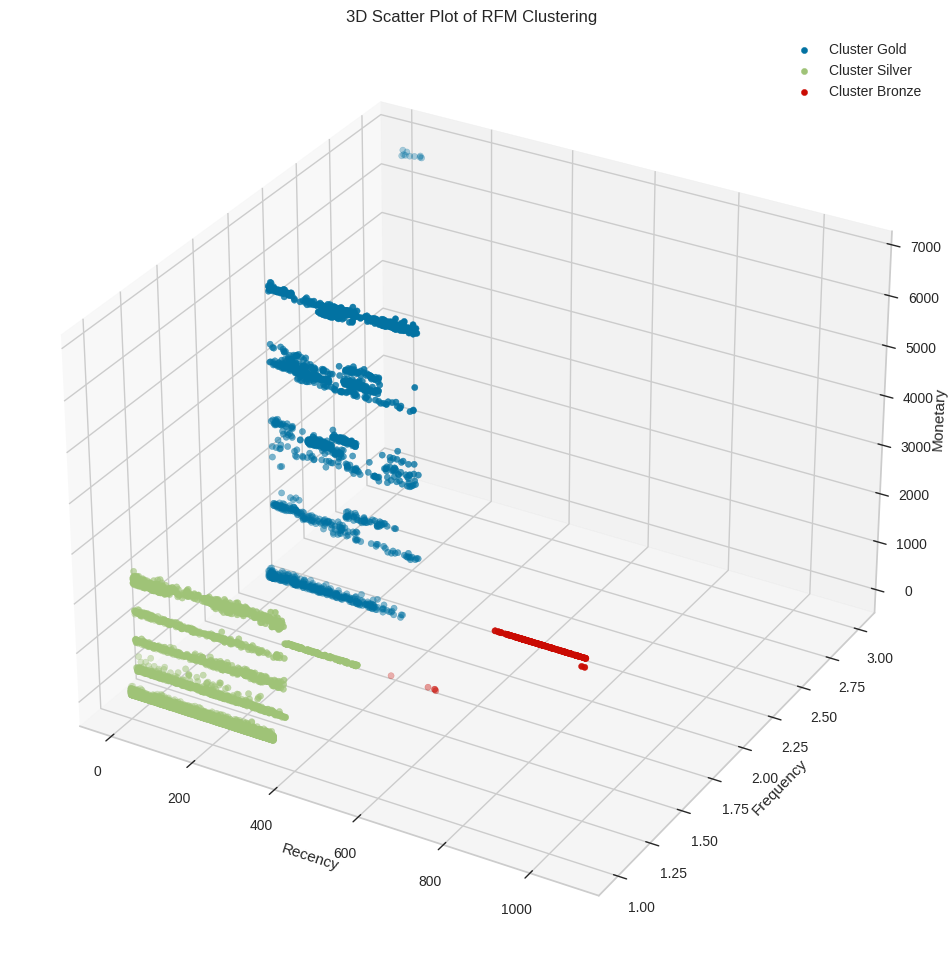

In [ ]:
# Create a 3D figure
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot points for each cluster
for cluster in rfm['Cluster label'].unique():
    cluster_data = rfm[rfm['Cluster label'] == cluster]
    ax.scatter(cluster_data['Recency'], cluster_data['Frequency'], cluster_data['Monetary'], label=f'Cluster {cluster}')

# Label the axes
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('3D Scatter Plot of RFM Clustering')

# Display the legend
ax.legend()

# Show the plot
plt.show()

The 3D scatter plot clearly shows that the model has effectively separated the customers into distinct clusters based on Recency, Frequency, and Monetary values.
This clear separation indicates that the clustering model is efficient in distinguishing different customer behaviors, enabling targeted marketing strategies for each group.

## Evaluation Metrics for Clustering Performance
I assess clustering quality using three key metrics:
- Silhouette Score (Higher is better, max=1): Measures how well data points fit within their clusters.
- Davies-Bouldin Score (Lower is better, min=0): Evaluates cluster compactness and separation.
- Calinski-Harabasz Score (Higher is better): Assesses the ratio of between-cluster to within-cluster dispersion.

In [ ]:
# Extract the cluster labels from the RFM dataset
kmeans_data = rfm['Cluster_Id']  # Ensure 'Cluster' column exists

# Compute evaluation metrics
silhouette = silhouette_score(scaled_rfm, kmeans_data)
davies_bouldin = davies_bouldin_score(scaled_rfm, kmeans_data)
calinski_harabasz = calinski_harabasz_score(scaled_rfm, kmeans_data)

# Store results in a dictionary
evaluation_results = {
    "Silhouette Score": silhouette,
    "Davies-Bouldin Score": davies_bouldin,
    "Calinski-Harabasz Score": calinski_harabasz
}

# Convert to DataFrame for easy visualization
evaluation_df = pd.DataFrame([evaluation_results])

# Display results
print(evaluation_df)


   Silhouette Score  Davies-Bouldin Score  Calinski-Harabasz Score
0          0.636487               0.56693              8227.645666


The Silhouette Score (0.636) indicates good cluster separation. The Davies-Bouldin Score (0.567) is low, suggesting well-separated clusters. The Calinski-Harabasz Score (8227.65) is high, confirming strong cluster separation. Overall, the model shows effective clustering with clear and distinct customer segments.